# DCGAN

In [4]:
DCGAN_MNIST_PATH = "/Users/mchrusci/uj/DCGAN-tensorflow/best_samples/"

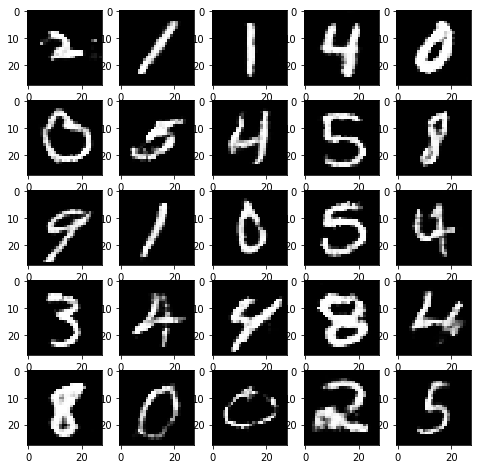

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
%matplotlib inline
import os
import fnmatch

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
all_samples = os.listdir(DCGAN_MNIST_PATH)
for i in range(1, columns * rows + 1):
    sample = np.random.choice(all_samples)
    img = mimg.imread(DCGAN_MNIST_PATH + sample)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [10]:
print(len(all_samples))

6401


# Primitives

In [13]:
INPUTS = "/Users/mchrusci/uj/DCGAN-tensorflow/best_samples/"
OUTPUTS = "/Users/mchrusci/uj/gimp-drawer/result/primitives/dcgan/png/"
N = 100
MODES = range(9)
NUM_ACTIONS = 100

In [11]:
from tqdm import tqdm_notebook as tqdm

In [11]:
for mode in MODES:
    for _ in tqdm(range(N)):
        sample = np.random.choice(all_samples)
        input_path = "{}{}".format(INPUTS, sample)
        output = sample.split(".")[0]
        output_path = "{}{}-mode-{}-n-%d.png".format(OUTPUTS, output, mode)
        cmd = "/Users/mchrusci/go/bin/primitive -i {} -o {} -n {} -m {} -s 28".format(input_path, output_path, NUM_ACTIONS, mode)
        os.system(cmd)

### speed (28x28, n = 100)

| mode | speed (s/img) | descripton     |
|------|---------------|----------------|
| 0    | 4.36          | combo          |
| 1    | 2.01          | triangle       |
| 2    | 1.65          | rect           |
| 3    | 3.79          | ellipse        |
| 4    | 4.46          | circle         |
| 5    | 2.90          | rotatedrect    |
| 6    | 4.44          | beziers        |
| 7    | 11.18         | rotatedellipse |
| 8    | 4.76          | polygon        |

## Rysunki

In [46]:
drawings = os.listdir(OUTPUTS)
group_by_modes = [[drawing for drawing in drawings if fnmatch.fnmatch(drawing, "*mode-{}*".format(mode))] for mode in MODES]
sample_drawing_per_mode = [np.random.choice(one_mode_drawings) for one_mode_drawings in group_by_modes]
sample_per_mode_without_actions = [sample.split('-n-')[0] for sample in sample_drawing_per_mode]
all_actions = [[drawing for drawing in drawings if fnmatch.fnmatch(drawing, "{}*".format(sample))] for sample in sample_per_mode_without_actions]
all_actions_paths = [[OUTPUTS + action for action in mode] for mode in all_actions]

In [47]:
inputs = os.listdir(INPUTS)
sample_names = [sample.split('-mode-')[0] for sample in sample_per_mode_without_actions]
inputs_for_drawings = [inp for sample in sample_names for inp in inputs if fnmatch.fnmatch(inp, "{}*".format(sample))]
inputs_paths = [INPUTS + inp for inp in inputs_for_drawings]

In [48]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

sorted_drawings = [sorted(paths, key=natural_keys) for paths in all_actions_paths]

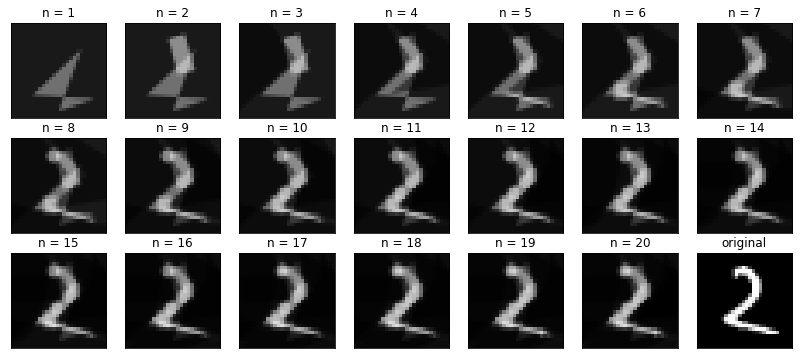

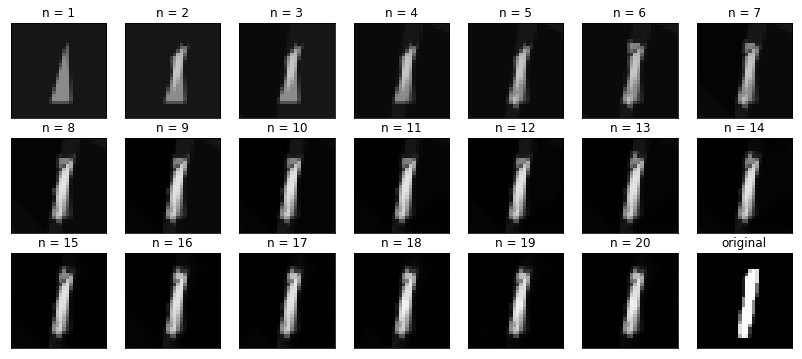

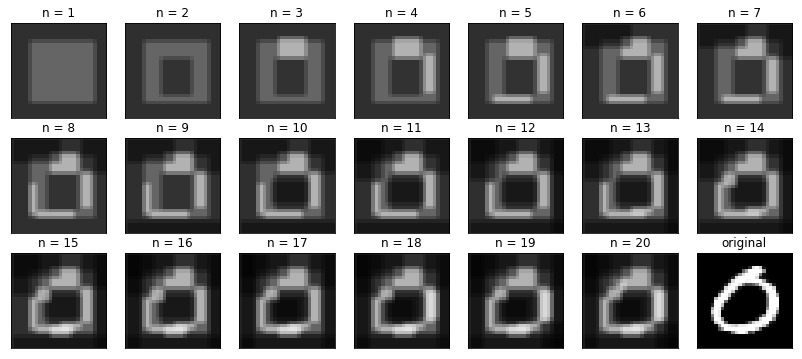

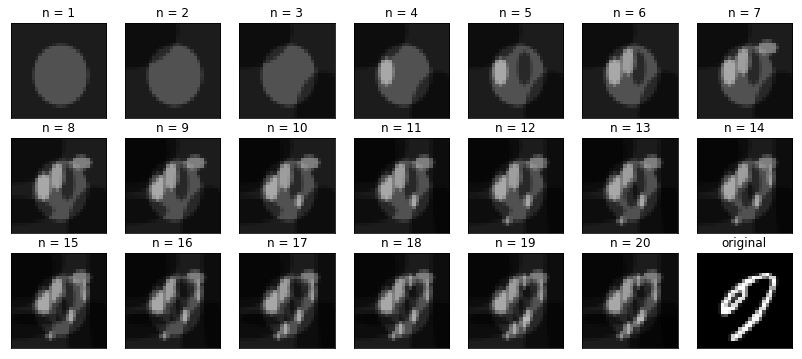

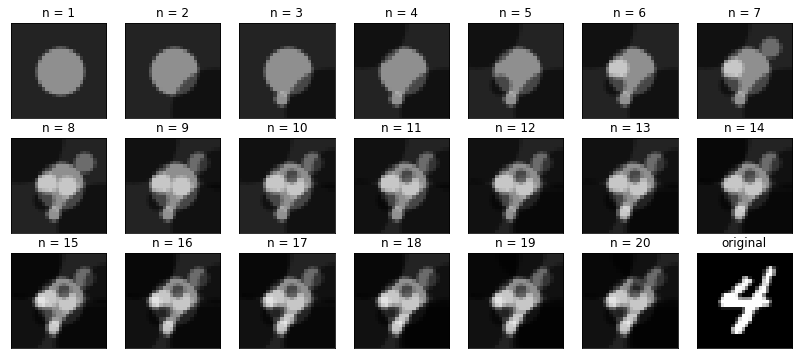

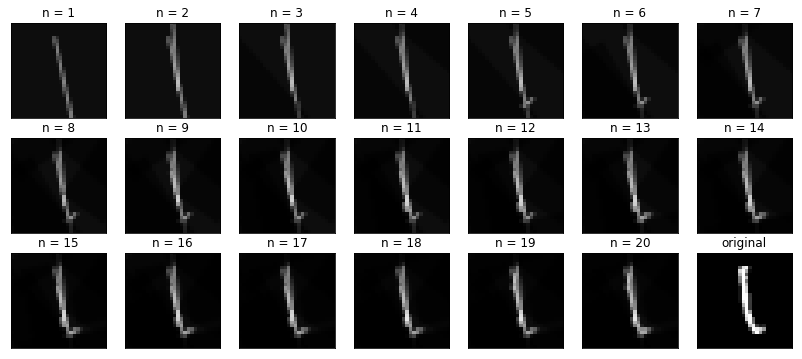

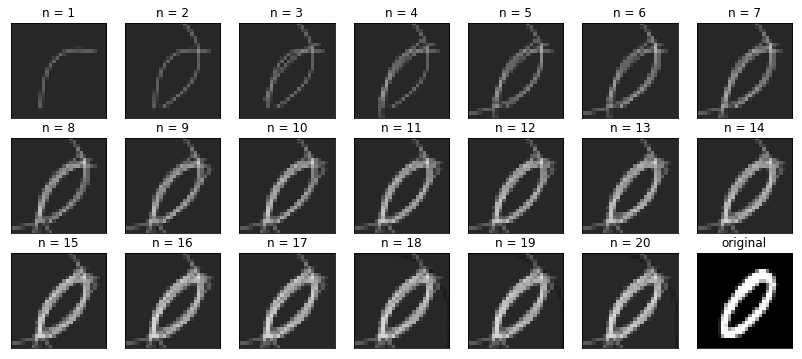

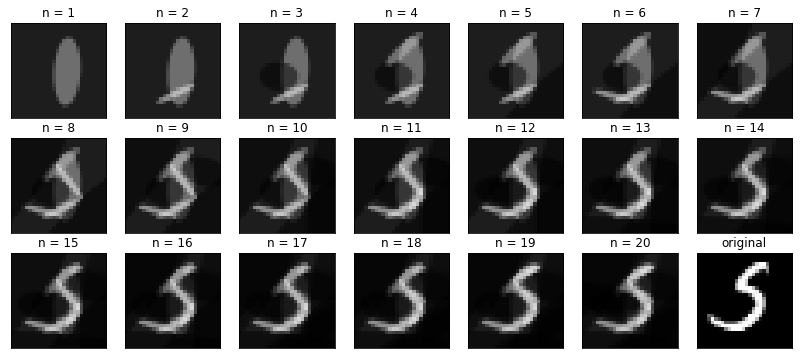

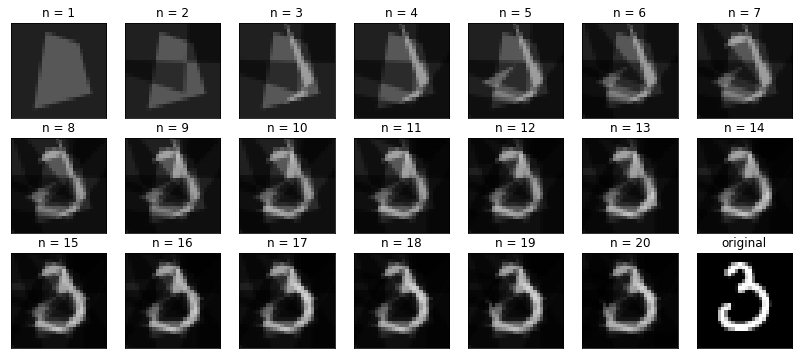

In [49]:
in_out = zip(inputs_paths, sorted_drawings)
for inp, out in in_out:
    fig = plt.figure(figsize=(14, 6))
    columns = 7
    rows = 3
    for i in range(1, columns * rows - 1):
        img = mimg.imread(out[i-1])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('n = {}'.format(i))
        
    img = mimg.imread(out[19])
    fig.add_subplot(rows, columns, columns * rows - 1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('n = {}'.format(20))
        
    img = mimg.imread(inp)
    fig.add_subplot(rows, columns, columns * rows)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('original')
    plt.show()

Przykładowe wyniki dla każdego z możliwych modów rysowania. Pierwsze 20 obrazków = kolejne akcje, ostatni obrazek = oryginał

# Przygotowanie rysunków pod klasyfikację i analizę

In [45]:
drawings = os.listdir(OUTPUTS)
drawings = [drawing for drawing in drawings if drawing != '.DS_Store' and drawing != 'inception']

In [46]:
print(len(drawings))
print(drawings[0:10])

88900
['test_arange_58-0-8-mode-4-n-95.png', 'test_arange_10-12-9-mode-8-n-35.png', 'test_arange_75-32-5-mode-5-n-87.png', 'test_arange_16-4-5-mode-1-n-94.png', 'test_arange_35-26-3-mode-3-n-17.png', 'test_arange_57-11-0-mode-0-n-90.png', 'test_arange_76-1-6-mode-4-n-17.png', 'test_arange_66-41-6-mode-0-n-76.png', 'test_arange_67-57-8-mode-6-n-68.png', 'test_arange_55-37-9-mode-1-n-25.png']


In [47]:
def mode_matches(name, mode):
    try:
        actual_mode = name.split('-mode-')[1].split('-n-')[0]
    except IndexError:
        print(name, mode)
    return mode == int(actual_mode)

def action_matches(name, action):
    actual_action = name.split('-n-')[1].split('.')[0]
    return action == int(actual_action)

grouped_by_mode = [[drawing for drawing in drawings if mode_matches(drawing, mode)] for mode in MODES]
grouped_by_mode_and_action = [[drawing for drawing in group if action_matches(drawing, action)] for group in grouped_by_mode for action in range(1, N + 1)]

In [48]:
DATASET = "/Users/mchrusci/uj/gimp-drawer/result/primitives/dcgan/numpy/"

In [49]:
import numpy as np

for group in grouped_by_mode_and_action:
    mode = group[0].split('-mode-')[1].split('-n-')[0]
    action = group[0].split('-n-')[1].split('.')[0]
    X = np.zeros((len(group), 28, 28, 1))
    Y = np.zeros((len(group), 1))
    
    for idx, sample in enumerate(group):
        label = sample.split('-mode-')[0][-1]
        img = mimg.imread(OUTPUTS + sample)[:,:,0]
        X[idx] = img.reshape((28, 28, 1))
        Y[idx] = np.array([int(label)])
                          
    np.savez(DATASET + "dcgan-mnist-mode-{}-n-{}".format(mode, action), X=X, Y=Y)

[8.]


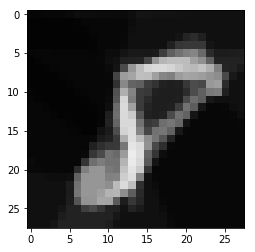

In [51]:
# SPRAWDZENIE CZY ZAPISANE DANE MAJA SENS
mode = np.random.choice(MODES)
action = np.random.choice(range(1, N + 1))
with np.load(DATASET + 'dcgan-mnist-mode-{}-n-{}.npz'.format(mode, action)) as data:
    X = data['X']
    Y = data['Y']
    idx = np.random.choice(range(len(X)))
    x = X[idx]
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    plt.imshow(x, cmap='gray')
    print(Y[idx])

[2.]


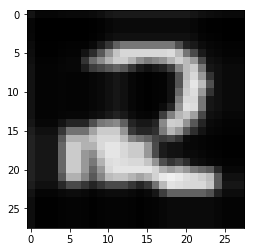

In [52]:
mode = np.random.choice(MODES)
action = np.random.choice(range(1, N + 1))
with np.load(DATASET + 'dcgan-mnist-mode-{}-n-{}.npz'.format(mode, action)) as data:
    X = data['X']
    Y = data['Y']
    idx = np.random.choice(range(len(X)))
    x = X[idx]
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    plt.imshow(x, cmap='gray')
    print(Y[idx])

[1.]


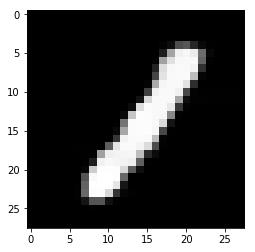

In [53]:
mode = np.random.choice(MODES)
action = np.random.choice(range(1, N + 1))
with np.load(DATASET + 'dcgan-mnist-mode-{}-n-{}.npz'.format(mode, action)) as data:
    X = data['X']
    Y = data['Y']
    idx = np.random.choice(range(len(X)))
    x = X[idx]
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    plt.imshow(x, cmap='gray')
    print(Y[idx])

# Powtórka dla oryginalnego mnista

In [22]:
INPUTS = "/Users/mchrusci/uj/gimp-drawer/data/dataset/mnist/png/"
OUTPUTS = "/Users/mchrusci/uj/gimp-drawer/result/primitives/mnist/png/"
N = 100
MODES = range(9)
NUM_ACTIONS = 20

In [6]:
# PRZYGOTOWANIE N * len(MODES) SAMPLI Z TESTOWEGO MNISTA W PNG
def load_mnist():
    data_dir = "/Users/mchrusci/uj/gimp-drawer/data/dataset/mnist/bin/"

    fd = open(os.path.join(data_dir, 't10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    X = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)

    fd = open(os.path.join(data_dir, 't10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    Y = loaded[8:].reshape((10000)).astype(np.float)

    Y = np.asarray(Y)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(Y)

    return X / 255., Y

In [ ]:
X, Y = load_mnist()

In [124]:
seed = 666
np.random.seed(seed)
X_idx = np.random.choice(range(X.shape[0]), N * len(MODES))
np.random.seed(seed)
Y_idx = np.random.choice(range(Y.shape[0]), N * len(MODES))

In [126]:
X_samples = X[X_idx]
assert len(X_samples) == N * len(MODES)
Y_samples = Y[Y_idx]
assert len(X_samples) == N * len(MODES)

In [130]:
for idx, sample in enumerate(zip(X_samples, Y_samples)):
    x, y = sample
    name = "sample-{}-{}.png".format(idx, int(y))
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    mimg.imsave(INPUTS + name, x)

In [143]:
# NARYSOWANIE SAMPLI MNISTA PRZY POMOCY PRIMITIVES
sample_idx = 0
samples = os.listdir(INPUTS)
for mode in MODES:
    for _ in tqdm(range(N)):
        sample = samples[sample_idx]
        input_path = "{}{}".format(INPUTS, sample)
        output = sample.split(".")[0]
        output_path = "{}{}-mode-{}-n-%d.png".format(OUTPUTS, output, mode)
        cmd = "/Users/mchrusci/go/bin/primitive -i {} -o {} -n {} -m {} -s 28".format(input_path, output_path, NUM_ACTIONS, mode)
        os.system(cmd)
        sample_idx += 1

100%|██████████| 100/100 [01:44<00:00,  1.02s/it]


In [23]:
drawings = os.listdir(OUTPUTS)
group_by_modes = [[drawing for drawing in drawings if fnmatch.fnmatch(drawing, "*mode-{}*".format(mode))] for mode in MODES]
sample_drawing_per_mode = [np.random.choice(one_mode_drawings) for one_mode_drawings in group_by_modes]
sample_per_mode_without_actions = [sample.split('-n-')[0] for sample in sample_drawing_per_mode]
all_actions = [[drawing for drawing in drawings if fnmatch.fnmatch(drawing, "{}*".format(sample))] for sample in sample_per_mode_without_actions]
all_actions_paths = [[OUTPUTS + action for action in mode] for mode in all_actions]

In [24]:
inputs = os.listdir(INPUTS)
sample_names = [sample.split('-mode-')[0] for sample in sample_per_mode_without_actions]
inputs_for_drawings = [inp for sample in sample_names for inp in inputs if fnmatch.fnmatch(inp, "{}*".format(sample))]
inputs_paths = [INPUTS + inp for inp in inputs_for_drawings]

In [25]:
sorted_drawings = [sorted(paths, key=natural_keys) for paths in all_actions_paths]

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


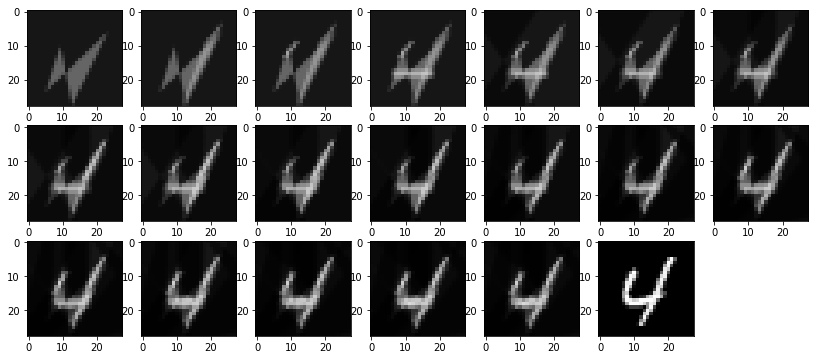

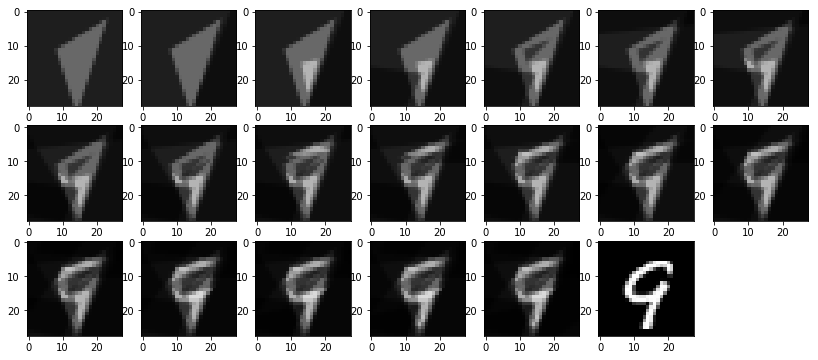

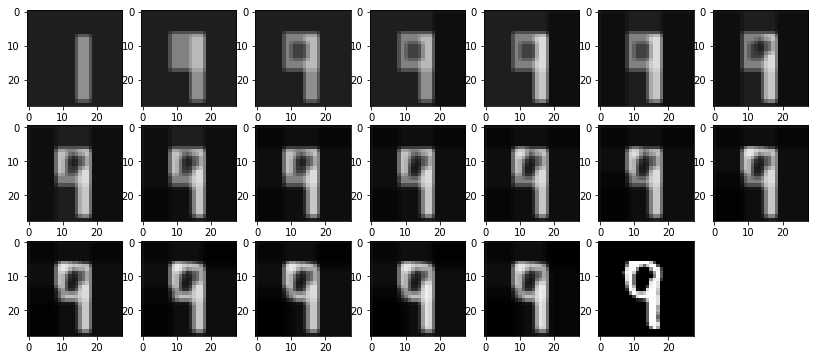

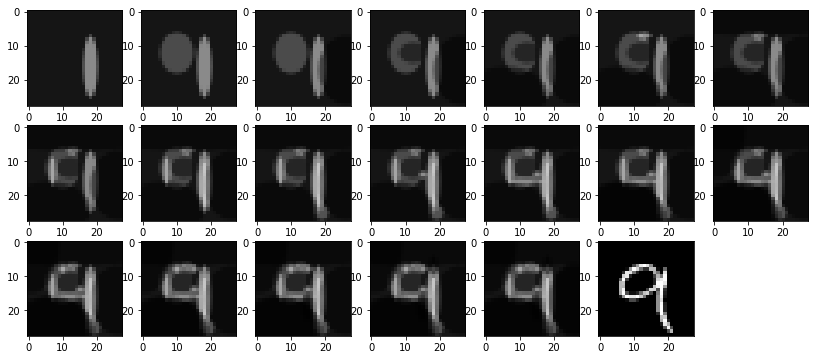

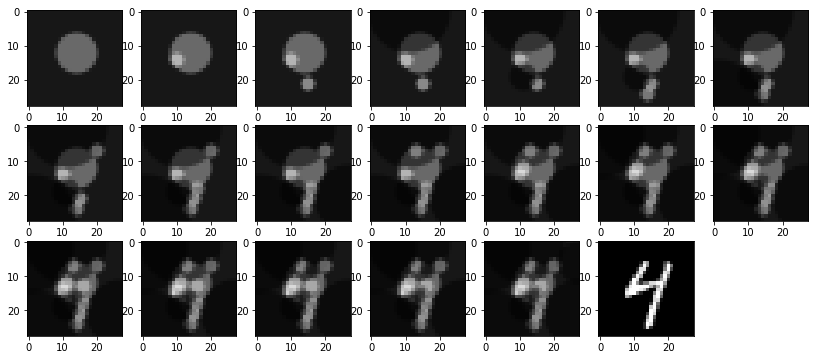

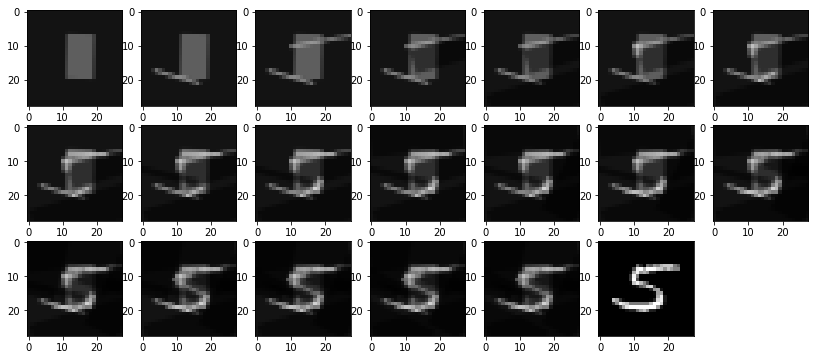

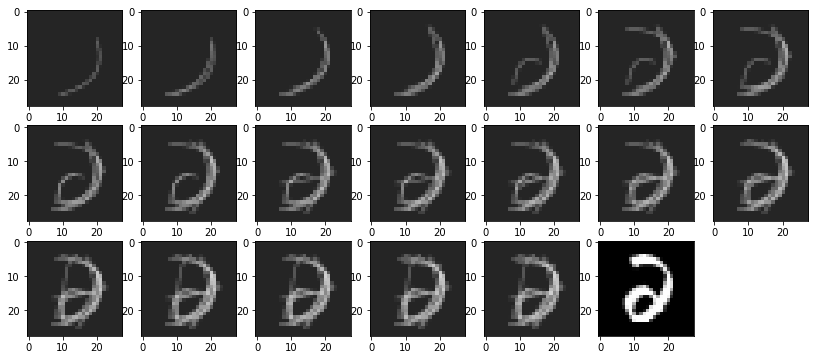

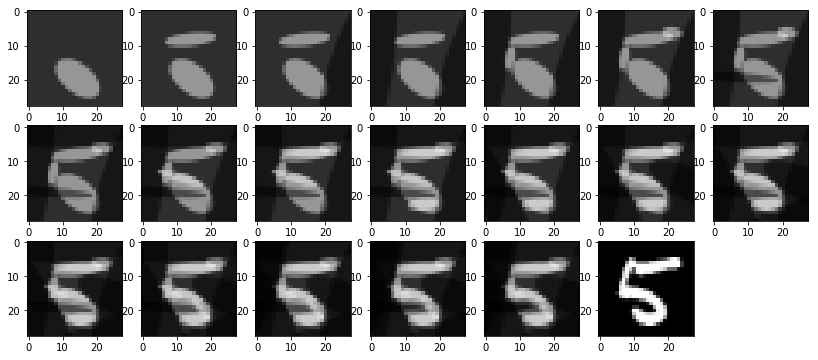

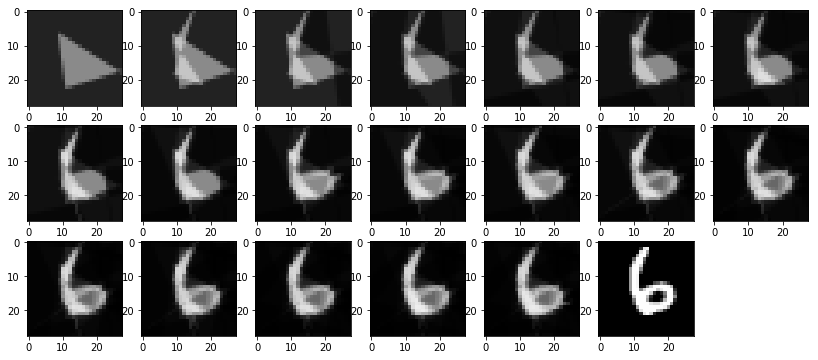

In [147]:
in_out = zip(inputs_paths, sorted_drawings)
for inp, out in in_out:
    fig = plt.figure(figsize=(14, 6))
    columns = 7
    rows = 3
    for i in range(1, columns * rows):
        img = mimg.imread(out[i-1])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
    img = mimg.imread(inp)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.show()

In [148]:
drawings = os.listdir(OUTPUTS)
drawings = [drawing for drawing in drawings if drawing != '.DS_Store']

In [149]:
grouped_by_mode = [[drawing for drawing in drawings if mode_matches(drawing, mode)] for mode in MODES]
grouped_by_mode_and_action = [[drawing for drawing in group if action_matches(drawing, action)] for group in grouped_by_mode for action in range(1, 21)]

In [150]:
DATASET = "/Users/mchrusci/uj/gimp-drawer/result/primitives/mnist/numpy/"

In [152]:
for group in grouped_by_mode_and_action:
    mode = group[0].split('-mode-')[1].split('-n-')[0]
    action = group[0].split('-n-')[1].split('.')[0]
    X = np.zeros((len(group), 28, 28, 1))
    Y = np.zeros((len(group), 1))
    
    for idx, sample in enumerate(group):
        label = sample.split('-mode-')[0][-1]
        img = mimg.imread(OUTPUTS + sample)[:,:,0]
        X[idx] = img.reshape((28, 28, 1))
        Y[idx] = np.array([int(label)])
                          
    np.savez(DATASET + "original-mnist-mode-{}-n-{}".format(mode, action), X=X, Y=Y)

[2.]


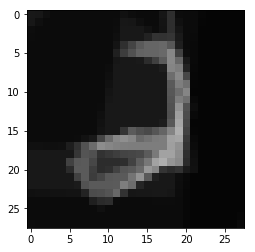

In [153]:
# SPRAWDZENIE CZY ZAPISANE DANE MAJA SENS
mode = np.random.choice(MODES)
action = np.random.choice(range(1, 21))
with np.load(DATASET + 'original-mnist-mode-{}-n-{}.npz'.format(mode, action)) as data:
    X = data['X']
    Y = data['Y']
    idx = np.random.choice(range(len(X)))
    x = X[idx]
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    plt.imshow(x, cmap='gray')
    print(Y[idx])

[8.]


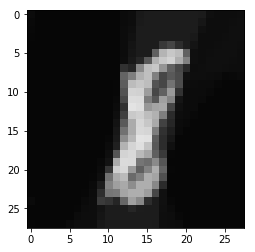

In [155]:
mode = np.random.choice(MODES)
action = np.random.choice(range(1, 21))
with np.load(DATASET + 'original-mnist-mode-{}-n-{}.npz'.format(mode, action)) as data:
    X = data['X']
    Y = data['Y']
    idx = np.random.choice(range(len(X)))
    x = X[idx]
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    plt.imshow(x, cmap='gray')
    print(Y[idx])

[9.]


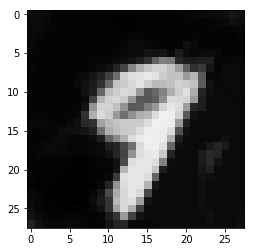

In [156]:
mode = np.random.choice(MODES)
action = np.random.choice(range(1, 21))
with np.load(DATASET + 'original-mnist-mode-{}-n-{}.npz'.format(mode, action)) as data:
    X = data['X']
    Y = data['Y']
    idx = np.random.choice(range(len(X)))
    x = X[idx]
    x = np.repeat(x.reshape(28, 28, 1), 3, axis=2)
    plt.imshow(x, cmap='gray')
    print(Y[idx])

# Classifier

| dataset     | CapsNet accuracy (trained on MNIST)|
|-------------|------------------------------------|
| MNIST       | 0.9932                             | 
| DCGAN MNIST | 0.9518                             | 

In [6]:
DCGAN_DATASETS = '/Users/mchrusci/uj/gimp-drawer/result/primitives/dcgan/numpy/'
RESULT_ACCS = '/Users/mchrusci/uj/CapsNet-Tensorflow/results/'

In [20]:
datasets = os.listdir(DCGAN_DATASETS)
print('datasets len', len(datasets))
print(datasets[0])

datasets len 901
dcgan-mnist-mode-7-n-63.npz


In [21]:
results = os.listdir(RESULT_ACCS)
test_acc_results = [x for x in results if x[0:14] == 'test_acc_dcgan']
processed_datasets = [x.split('test_acc_')[1].split('.')[0] for x in test_acc_results]
print('processed datasets len', len(processed_datasets))
filtered_datasets = [x for x in datasets if x.split('.')[0] not in processed_datasets]
print('filtered datasets len', len(filtered_datasets))

processed datasets len 334
filtered datasets len 567


In [22]:
for dataset in tqdm(filtered_datasets):
    cmd = '/anaconda3/bin/python /Users/mchrusci/uj/CapsNet-Tensorflow/main.py --dataset drawned-mnist --dataset_path {} --is_training=False'.format(DCGAN_DATASETS + dataset)
    os.system(cmd)

In [60]:
directory_files = os.listdir(RESULT_ACCS)
acc_files = [x for x in directory_files if x[0:14] == 'test_acc_dcgan']
accs = []
for acc_file in acc_files:
    with open(RESULT_ACCS + acc_file) as f:
        lines = f.readlines()
        if len(lines) > 1:
            mode = int(acc_file.split('-mode-')[1].split('-n-')[0])
            action = int(acc_file.split('-n-')[1].split('.')[0])
            acc = float(lines[1])
            accs.append({'mode': mode, 'action': action, 'acc': acc})
        else:
            mode = int(acc_file.split('-mode-')[1].split('-n-')[0])
            action = int(acc_file.split('-n-')[1].split('.')[0])
            accs.append({'mode': mode, 'action': action, 'acc': -1})
print(len(accs))

900


In [63]:
def find_acc(mode, action):
    for a in accs:
        if a['mode'] == mode and a['action'] == action:
            return a['acc']
    return 0.5

def fix(a):
    print('fixing', a)
    prev_acc = find_acc(a['mode'], a['action'] - 1)
    if prev_acc == -1:
        prev_acc = find_acc(a['mode'], a['action'] - 2)
    next_acc = find_acc(a['mode'], a['action'] + 1)
    if next_acc == - 1:
        next_acc = find_acc(a['mode'], a['action'] + 2)
    print('prev', prev_acc)
    print('next', next_acc)
    result = {'mode': a['mode'], 'action': a['action'], 'acc': (prev_acc + next_acc) / 2}
    print('returning', result)
    return result
    
fixed_accs = [fix(a) if a['acc'] == -1 else a for a in accs]

fixing {'mode': 8, 'action': 85, 'acc': -1}
prev 0.96
next 0.96
returning {'mode': 8, 'action': 85, 'acc': 0.96}
fixing {'mode': 6, 'action': 60, 'acc': -1}
prev 0.83
next 0.88
returning {'mode': 6, 'action': 60, 'acc': 0.855}
fixing {'mode': 3, 'action': 30, 'acc': -1}
prev 0.82
next 0.9
returning {'mode': 3, 'action': 30, 'acc': 0.86}
fixing {'mode': 2, 'action': 30, 'acc': -1}
prev 0.36
next 0.54
returning {'mode': 2, 'action': 30, 'acc': 0.45}
fixing {'mode': 1, 'action': 88, 'acc': -1}
prev 1.0
next 0.98
returning {'mode': 1, 'action': 88, 'acc': 0.99}
fixing {'mode': 4, 'action': 96, 'acc': -1}
prev 1.0
next 0.98
returning {'mode': 4, 'action': 96, 'acc': 0.99}
fixing {'mode': 8, 'action': 36, 'acc': -1}
prev 0.96
next 0.92
returning {'mode': 8, 'action': 36, 'acc': 0.94}
fixing {'mode': 8, 'action': 22, 'acc': -1}
prev 0.96
next 0.84
returning {'mode': 8, 'action': 22, 'acc': 0.8999999999999999}
fixing {'mode': 2, 'action': 21, 'acc': -1}
prev 0.24
next 0.96
returning {'mode': 2

In [64]:
print(len(fixed_accs))

900


## Liczba akcji a accurracy

In [65]:
N = 100

In [66]:
xs = range(1, N + 1)
sums = {k: 0 for k in xs}
action_occurences = {k: 0 for k in xs}
for x in xs:
    for acc in fixed_accs:
        if acc['action'] == x:
            sums[x] += acc['acc']
            action_occurences[x] += 1

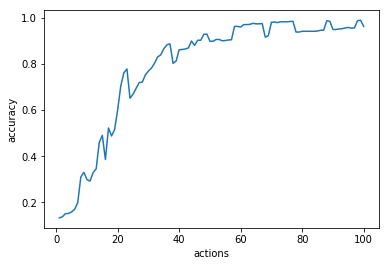

In [67]:
avg_accs = {k: (v / action_occurences[k]) for k, v in sums.items()}
plt.xlabel('actions')
plt.ylabel('accuracy')
plt.plot(avg_accs.keys(), avg_accs.values())

## Mode a accurracy

In [68]:
xs = range(0, 9)
sums = {k: 0 for k in xs}
mode_occurences = {k: 0 for k in xs}
for x in xs:
    for acc in fixed_accs:
        if acc['mode'] == x:
            sums[x] += acc['acc']
            mode_occurences[x] += 1

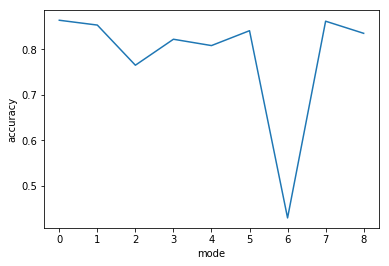

In [69]:
avg_accs = {k: (v / mode_occurences[k]) for k, v in sums.items()}
plt.xlabel('mode')
plt.ylabel('accuracy')
plt.plot(avg_accs.keys(), avg_accs.values())

| mode | descripton     |
|------|----------------|
| 0    | combo          |
| 1    | triangle       |
| 2    | rect           |
| 3    | ellipse        |
| 4    | circle         |
| 5    | rotatedrect    |
| 6    | beziers        |
| 7    | rotatedellipse |
| 8    | polygon        |

## Liczba akcji a accurracy dla ustalonego mode

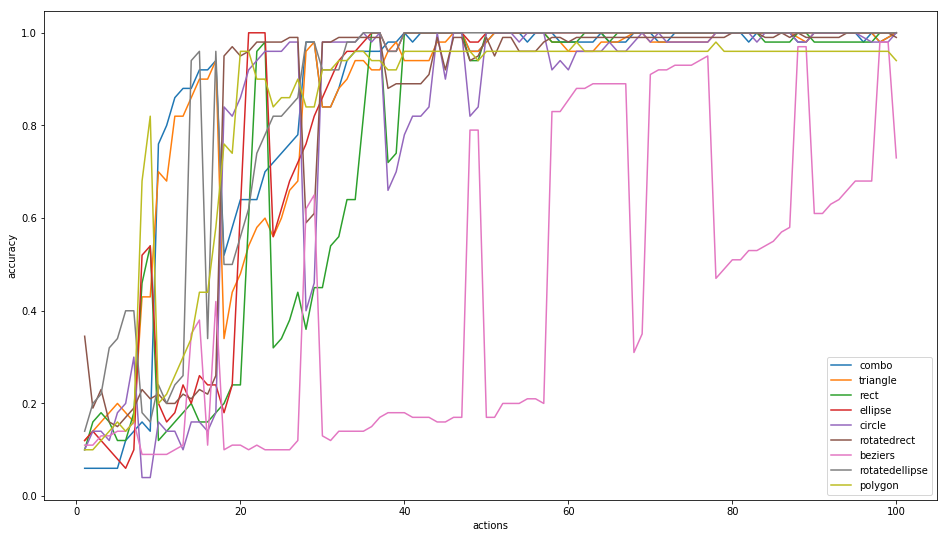

In [75]:
ys = []
for mode in range(9):
    xs = range(1, N + 1)
    names = {0: 'combo', 1: 'triangle', 2: 'rect', 3: 'ellipse', 4: 'circle', 5: 'rotatedrect', 6: 'beziers', 7: 'rotatedellipse', 8: 'polygon'}
    sums = {k: 0 for k in xs}
    mode_occurences = {k: 0 for k in xs}
    for x in xs:
        for acc in fixed_accs:
            if acc['mode'] == mode:
                if acc['action'] == x:
                    sums[x] += acc['acc']
                    mode_occurences[x] += 1
    avg_accs = {k: (v / mode_occurences[k]) for k, v in sums.items()}
    ys.append(avg_accs.values())
    
for y, label in zip(ys, names.values()):
    plt.plot(avg_accs.keys(), y, label=label)

plt.xlabel('actions')
plt.ylabel('accuracy')
plt.legend()
plt.rcParams["figure.figsize"] = [20,9]
plt.show()

# Frechet inception distance

## DCGAN MNIST vs narysowany DCGAN MNIST
1. wygenerowanie 5000 sampli z GANA
2. narysowanie 3000 losowych z nich (mode = polygons, actions = 20)
3. FID porównuje 3000 losowych z GANA (innych 3000 losowych niż te, które były rysowane) i 3000 narysowanych

In [13]:
DCGAN_PATH = '/Users/mchrusci/uj/DCGAN-tensorflow/best_samples/'
DRAWNED_PATH = '/Users/mchrusci/uj/gimp-drawer/result/primitives/dcgan/png/inception/'
NUM_SAMPLES = 2483
MODE = 0 # combo
NUM_ACTIONS = 100

In [8]:
dcgan_samples = os.listdir(DCGAN_PATH)
dcgan_samples = [x for x in dcgan_samples if x.startswith('test_arange')]
print(len(dcgan_samples))

6400


In [9]:
samples_to_draw = np.random.choice(dcgan_samples, NUM_SAMPLES)
len(samples_to_draw)

2483

In [ ]:
for sample in tqdm(samples_to_draw):
    input_path = "{}{}".format(DCGAN_PATH, sample)
    output = sample.split(".")[0]
    output_path = "{}{}-mode-{}-n-%d.png".format(DRAWNED_PATH, output, MODE)
    cmd = "/Users/mchrusci/go/bin/primitive -i {} -o {} -n {} -m {} -s 28".format(input_path, output_path, NUM_ACTIONS, MODE)
    os.system(cmd)

In [2]:
DCGAN_INCEPTION_SAMPLES = '/Users/mchrusci/uj/DCGAN-tensorflow/samples/inception/'
DRAWNED_INCEPTION_SAMPLES = '/Users/mchrusci/uj/gimp-drawer/result/primitives/dcgan/png/inception/'
NUM_SAMPLES = 2483

In [116]:
dcgan_samples = os.listdir(DCGAN_PATH)
dcgan_samples = [x for x in dcgan_samples if x.startswith('test_arange')]
samples_to_compare = np.random.choice(dcgan_samples, NUM_SAMPLES - len(os.listdir(DCGAN_INCEPTION_SAMPLES)))
print(len(samples_to_compare))

0


In [115]:
for sample in samples_to_compare:
    os.rename(DCGAN_PATH + sample, DCGAN_INCEPTION_SAMPLES + sample)

In [117]:
assert len(os.listdir(DCGAN_INCEPTION_SAMPLES)) == NUM_SAMPLES
assert len(os.listdir(DRAWNED_INCEPTION_SAMPLES)) == NUM_SAMPLES